In [1]:
import tensorflow as tf
import tensorflow_addons as tfa

In [43]:
import glob
import sys
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
sys.path.append('../')

In [4]:
import helper_functions
import my_networks

## Network

In [5]:
g_in_channels = 4
g_out_channels = 4
f_in_channels = 4
f_out_channels = 4

#generator_tc2oc = my_networks.unet_generator(g_out_channels, norm_type='instancenorm', input_channels=g_in_channels)
#generator_oc2tc = my_networks.unet_generator(f_out_channels, norm_type='instancenorm', input_channels=f_in_channels)

network = 'unet'

if network == 'resnet':
    generator_t2o = my_networks.resnet_generator(n_resnet=9, size=512, input_channels=g_in_channels, output_channels=g_out_channels)
    generator_o2t = my_networks.resnet_generator(n_resnet=9, size=512, input_channels=f_in_channels, output_channels=f_out_channels)

    # unet and resnet use the same discriminator
    discriminator_t = my_networks.unet_discriminator(norm_type='instancenorm', target=False, channels=4, size=512)
    discriminator_o = my_networks.unet_discriminator(norm_type='instancenorm', target=False, channels=4, size=512)
elif network == 'unet':
    generator_t2o = my_networks.unet_generator(g_out_channels, norm_type='instancenorm', input_channels=g_in_channels, size=512)
    generator_o2t = my_networks.unet_generator(f_out_channels, norm_type='instancenorm', input_channels=f_in_channels, size=512)

    # unet and resnet use the same discriminator
    discriminator_t = my_networks.unet_discriminator(norm_type='instancenorm', target=False, channels=4, size=512)
    discriminator_o = my_networks.unet_discriminator(norm_type='instancenorm', target=False, channels=4, size=512)
else:
    print('Unexpected network parameter')

In [6]:
class MyLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, initial_learning_rate, batch_size):
        self.initial_learning_rate = initial_learning_rate
        self.batch_size = batch_size

    def __call__(self, step):
        return tf.cond((step / self.batch_size) < 100, lambda: self.initial_learning_rate, lambda: self.initial_learning_rate - ((step / self.batch_size) - 100) * (self.initial_learning_rate / 100))

In [7]:
# CycleGAN paper uses 2e-4
# LSGAN paper uses 1e-3
generator_t2o_optimizer = tf.keras.optimizers.Adam(MyLRSchedule(2e-4, 1000), beta_1=0.5)
generator_o2t_optimizer = tf.keras.optimizers.Adam(MyLRSchedule(2e-4, 1000), beta_1=0.5)

discriminator_t_optimizer = tf.keras.optimizers.Adam(MyLRSchedule(1e-4, 1000), beta_1=0.5)
discriminator_o_optimizer = tf.keras.optimizers.Adam(MyLRSchedule(1e-4, 1000), beta_1=0.5)

In [8]:
if network == 'resnet':
    checkpoint_path = '../data/checkpoints/dishwasherRGBD'
elif network == 'unet':
    checkpoint_path = "../data/checkpoints/dishwasherRGBD-unet"

ckpt = tf.train.Checkpoint(generator_t2o=generator_t2o,
                           generator_o2t=generator_o2t,
                           discriminator_t=discriminator_t,
                           discriminator_o=discriminator_o,
                           generator_t2o_optimizer=generator_t2o_optimizer,
                           generator_o2t_optimizer=generator_o2t_optimizer,
                           discriminator_t_optimizer=discriminator_t_optimizer,
                           discriminator_o_optimizer=discriminator_o_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored')

Latest checkpoint restored


In [69]:
def generate_test_t2o():
    return helper_functions.generate_samples(cleargrasp_transparent_depth_test_cs_rz, len(cleargrasp_transparent_depth_test_cs_rz), generator_td2od)

def generate_val_t2o():
    return helper_functions.generate_samples(cleargrasp_transparent_depth_val_cs_rz, len(cleargrasp_transparent_depth_val_cs_rz), generator_td2od)

In [70]:
import cleargrasp_test_set
cleargrasp_transparent_test, \
cleargrasp_transparent_val, \
cleargrasp_masks_test, \
cleargrasp_masks_val = cleargrasp_test_set.generate_test_and_val()

In [71]:
def plot_depth_bin(img, min_depth=MIN_DEPTH, max_depth=MAX_DEPTH, vis_min=MIN_DEPTH, vis_max=MAX_DEPTH, colorbar=False):
    return helper_functions.plot_depth_bin(img, min_depth, max_depth, vis_min, vis_max, colorbar)

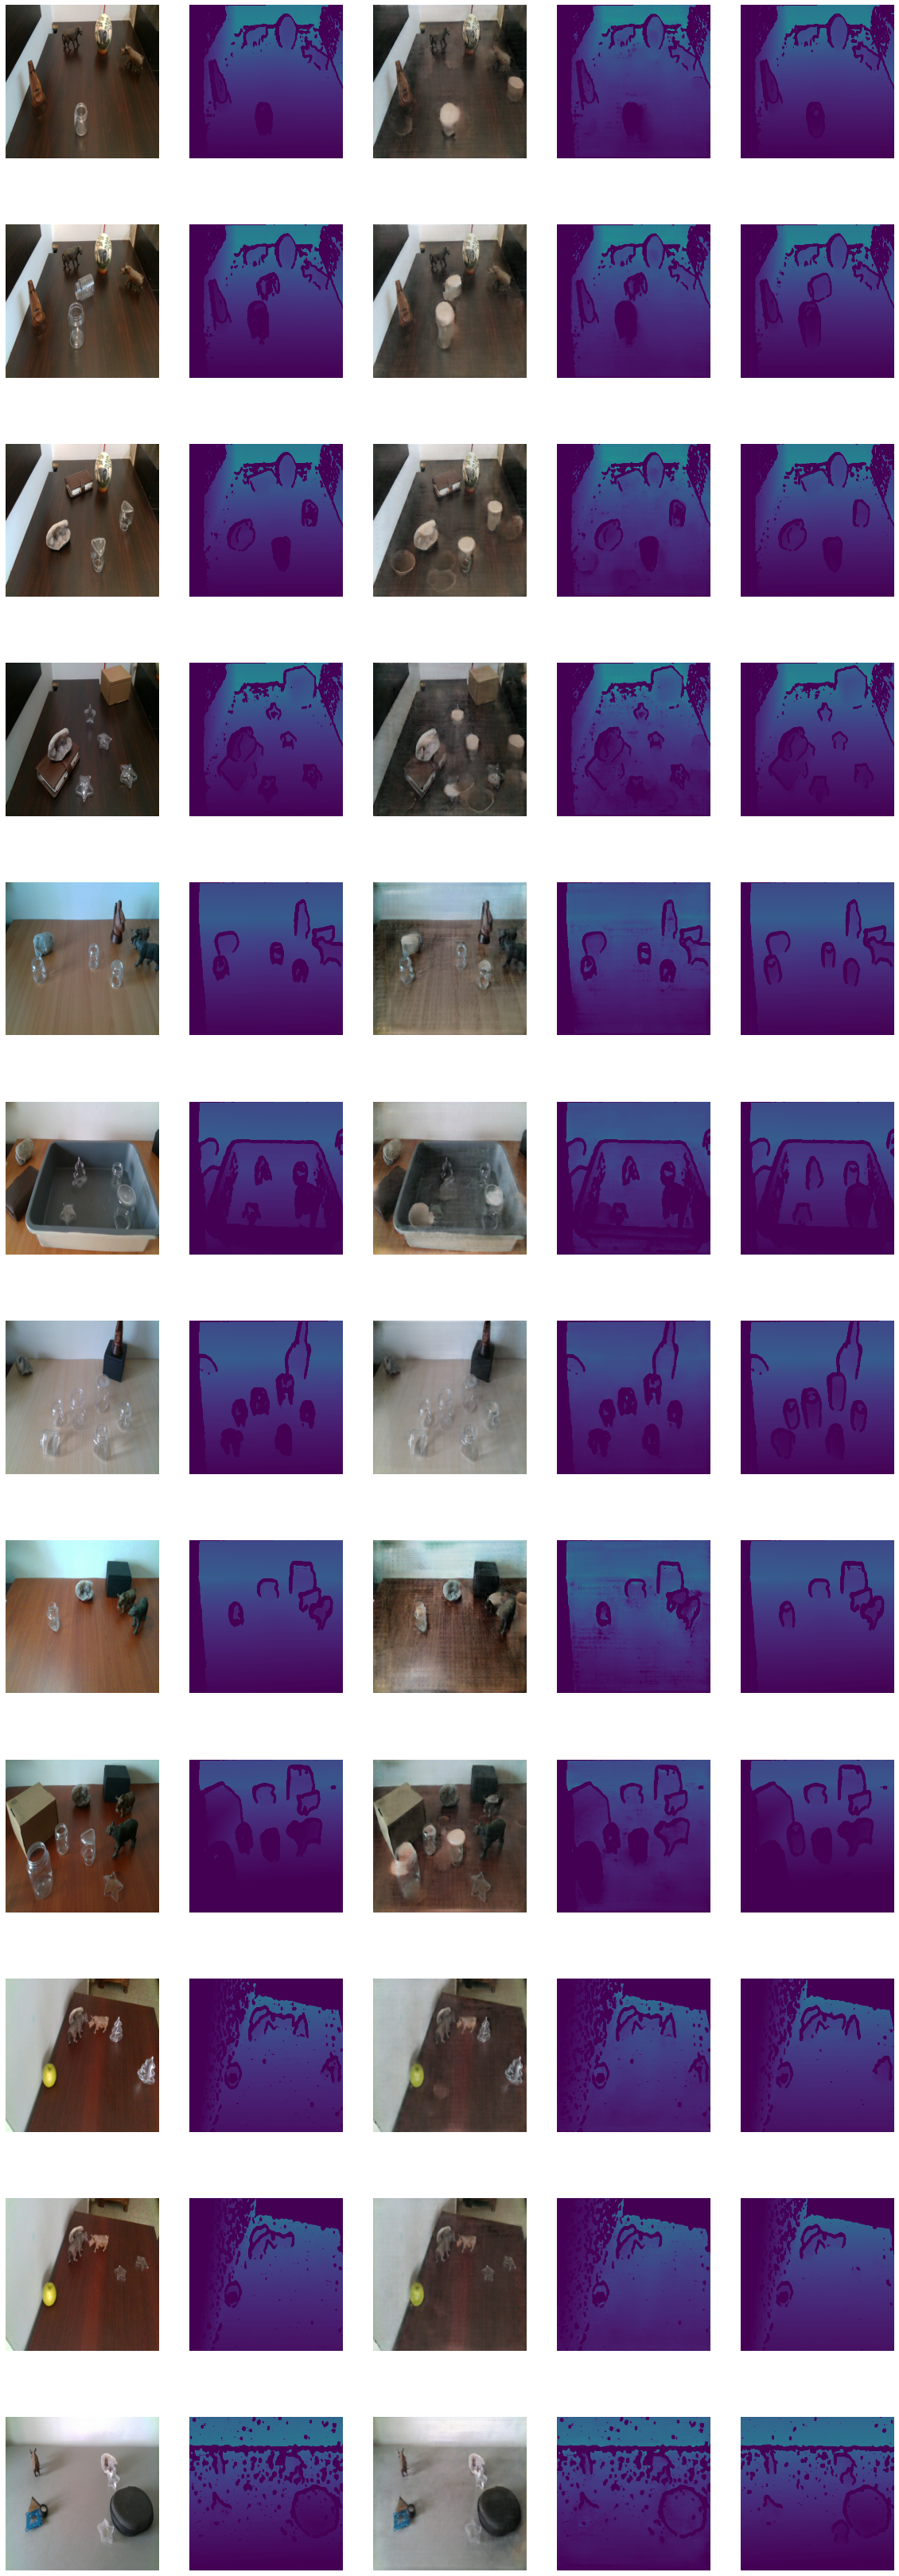

In [74]:
rows = len(generated_test)
cols = 5
plt.figure(figsize=(20, 60))

for i in range(rows):
    rgb_in = cleargrasp_transparent_test[i][:,:,1:4]
    depth_in = cleargrasp_transparent_test[i][:,:,0]
    
    rgb = generated_test[i][:,:,1:4]
    depth = generated_test[i][:,:,0]
    
    counter = 1
    plt.subplot(rows, cols, i*cols+counter)
    plt.imshow(rgb_in * 0.5 + 0.5)
    plt.axis('off')
    counter+=1
    
    plt.subplot(rows, cols, i*cols+counter)
    plot_depth_bin(depth_in)
    counter+=1
    
    plt.subplot(rows, cols, i*cols+counter)
    plt.imshow(rgb * 0.5 + 0.5)
    plt.axis('off')
    counter+=1
    
    plt.subplot(rows, cols, i*cols+counter)
    plot_depth_bin(depth)
    counter+=1
    
    plt.subplot(rows, cols, i*cols+counter)
    plot_depth_bin(cleargrasp_opaque_depth_test_cs_rz[i])
    counter+=1

In [75]:
rmse = lambda error: np.sqrt(np.mean(np.square(error)))
mae = lambda error: np.mean(np.abs(error))
me = lambda error: np.mean(error)
rel = lambda estimated, gt: np.abs(estimated - gt) / gt
def thresh(estimated, gt, theta, mask):
    r = rel(estimated, gt)[mask]
    return len(r[r < theta]) / len(r)

In [83]:
generated_test[0][:,:,0][(helper_functions.decenter_and_descale_cleargrasp(cleargrasp_opaque_depth_test_cs_rz[0], 2.0) != 0) & (cleargrasp_masks_test[0] == 1)]

array([], dtype=float32)

In [82]:
rel(helper_functions.decenter_and_descale_cleargrasp(generated_test[0][:,:,0], 2.0), helper_functions.decenter_and_descale_cleargrasp(cleargrasp_opaque_depth_test_cs_rz[0], 2.0))[(helper_functions.decenter_and_descale_cleargrasp(cleargrasp_opaque_depth_test_cs_rz[0], 2.0) != 0) & (cleargrasp_masks_test[0] == 1)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


array([], dtype=float32)

In [78]:
def evaluate():
    data = []
    for i in range(len(generated_test)):
        masks_matching = cleargrasp_masks_test
        depth = generated_test[i][:,:,0]
        gt = cleargrasp_opaque_depth_test_cs_rz[i]
        gt_raw = helper_functions.decenter_and_descale_cleargrasp(gt, 2.0)
        depth = generated_test[i][:,:,0]
        cg_raw = helper_functions.decenter_and_descale_cleargrasp(depth, 2.0)
        
        rel_depth_gt = rel(cg_raw, gt_raw)[gt_raw != 0]
        rel_depth_gt_match = rel(cg_raw, gt_raw)[(gt_raw != 0) & (masks_matching[i] == 1)]
        
        data.append([rmse(gt_raw - cg_raw),
                     rmse((cg_raw - gt_raw)[(masks_matching[i] == 1) & (gt_raw != 0)]),
                     mae(gt_raw - cg_raw),
                     mae((cg_raw - gt_raw)[(masks_matching[i] == 1) & (gt_raw != 0)]),
                     np.mean(rel_depth_gt),
                     np.mean(rel_depth_gt_match),
                     thresh(cg_raw, gt_raw, 0.05, masks_matching[i] == 1),
                     thresh(cg_raw, gt_raw, 0.10, masks_matching[i] == 1),
                     thresh(cg_raw, gt_raw, 0.25, masks_matching[i] == 1),
                     thresh(cg_raw, gt_raw, (math.pow(1.25, 2) - 1), masks_matching[i] == 1),
                     thresh(cg_raw, gt_raw, (math.pow(1.25, 3) - 1), masks_matching[i] == 1)
                    ])
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.width', 1000)
    df = pd.DataFrame(data, 
                      columns=["RMSE(ClearGrasp, GT)", 
                               "Masked RMSE(ClearGrasp, GT)", 
                               "MAE(ClearGrasp, GT)", 
                               "Masked MAE(ClearGrasp, GT)", 
                               "Relative error",
                               "Relative error (masked)",
                               "1.05",
                               "1.10",
                               "1.25",
                               "1.25 ** 2",
                               "1.25 ** 3"])
    df.loc['mean'] = df.mean()
    print(df)
        
evaluate()

      RMSE(ClearGrasp, GT)  Masked RMSE(ClearGrasp, GT)  MAE(ClearGrasp, GT)  Masked MAE(ClearGrasp, GT)  Relative error  Relative error (masked)      1.05      1.10      1.25  1.25 ** 2  1.25 ** 3
0                 0.162862                          NaN             0.096695                         NaN        0.072854                      NaN  0.000000  0.000000  0.000000   0.000000   0.000000
1                 0.170350                     0.193076             0.102536                    0.106638        0.077714                 0.162000  0.214286  0.214286  0.214286   0.214286   0.285714
2                 0.166166                     0.018007             0.095372                    0.014736        0.069714                 0.025550  0.333333  0.444444  0.444444   0.444444   0.444444
3                 0.160347                     0.148109             0.095307                    0.095523        0.076260                 0.173623  0.230769  0.307692  0.307692   0.461538   0.461538
4         

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
